# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: КУКАНОВА АБИНА ДЕНИСОВНА

In [ ]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.optim import Optimizer, Adam

import os
import gzip
import matplotlib.pyplot as plt

## 1. Загрузка данных (2 балла)

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Это не совсем про тексты, но зато он численный и его можно вытянуть в вектор. Это легко и полезно, чтобы отработать разные приемы. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [ ]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [ ]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

**t10k is the test data for Fashion Mnist**

In [ ]:
class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
      kind = 'train' if train else 't10k'
      self.images, self.labels = load_mnist(path, kind=kind)
      self.images = np.asarray(self.images).reshape(-1, 28, 28).astype('float32')

      self.image_transform = image_transform
      self.label_transform = label_transform

    def __len__(self,):
      return len(self.labels)

    def __getitem__(self, idx):
      image = self.images[idx]
      label = self.labels[idx]


      if self.image_transform is not None:
        image = self.image_transform(image)


      if self.label_transform is not None:
        label = self.label_transform(label)

      return image, label

In [ ]:
test_dataset = FashionMnist("data/FashionMNIST/raw", train=False)
train_dataset = FashionMnist("data/FashionMNIST/raw")

**Контроль:**

In [ ]:
type(train_dataset[0][0])

numpy.ndarray

In [ ]:
type(train_dataset[0][1])

numpy.uint8

Визуализируйте случайные элементы набора данных.

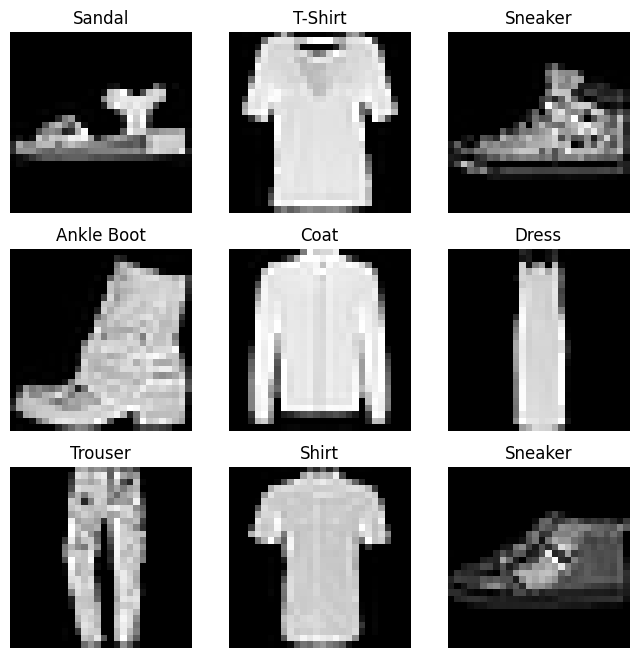

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [ ]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        image = torch.tensor(image, dtype=torch.float32)
        return image

# SHOULD BE CALLABLE ToTensor(x)
transform = ToTensor()

**Контроль:**

In [ ]:
type(train_dataset[0][0])

numpy.ndarray

In [ ]:
transform = ToTensor()

dt = transform(train_dataset[0][0])
print(type(dt))

<class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [ ]:
def my_collate(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)
    return images, labels

Убедитесть, что все работает корректно.

**Контроль:**

In [ ]:
train_dataset = FashionMnist("data/FashionMNIST/raw",
                             train=True,
                             image_transform=ToTensor())

test_dataset = FashionMnist("data/FashionMNIST/raw",
                            train=False,
                            image_transform=ToTensor())

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True, collate_fn=my_collate)
test_dataloader = DataLoader(test_dataset, batch_size=15, shuffle=False, collate_fn=my_collate)

In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (3 балла)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [ ]:
from torch.autograd import Function

class IdentityFunction(Function):
    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [ ]:
class IdentityLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [ ]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.clamp(input, min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        out = (input > 0).float()
        return grad_output * out

In [ ]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLUFunction.apply

    def forward(self, input):

        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [ ]:
torch.manual_seed(0)

x = torch.rand((7,15), requires_grad = True, dtype=torch.double)
relu = ReLU()

assert gradcheck(relu, x)

In [ ]:
torch_relu = torch.relu
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [ ]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):

        ctx.save_for_backward(inp, weight, bias)

        output = inp @ weight.T + bias
        return output

    @staticmethod
    def backward(ctx, grad_output):

        inp, weight, bias = ctx.saved_tensors


        grad_input = grad_output @ weight
        grad_weight = grad_output.T @ inp
        grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units, dtype=torch.float):
        super(Linear, self).__init__()

        self.weight = nn.Parameter(torch.randn(output_units, input_units,  dtype=dtype) * 0.01)
        self.bias = nn.Parameter(torch.randn(output_units,  dtype=dtype) * 0.01)

        self.linear = LinearFunction.apply

    def forward(self, inp):
        return self.linear(inp, self.weight, self.bias)

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [ ]:
torch.manual_seed(0)

x = torch.rand((6,12), requires_grad = True, dtype=torch.double)
linear = Linear(12, 14, dtype=torch.double)

assert gradcheck(linear, x)

Сравнение с `PyTorch`.

In [ ]:
output_units = 32
input_units = 15

x = torch.rand((16,15), requires_grad = True, dtype=torch.double)


weight = torch.rand(size=(output_units, input_units), dtype=torch.double)
bias = torch.rand(size=(output_units,), dtype=torch.double)

torch_linear = torch.nn.Linear(input_units, output_units, dtype=torch.double)
our_linear = Linear(input_units, output_units, dtype=torch.double)


state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)



torch_forward = torch_linear.forward(x)
our_forward = our_linear(x)
assert torch.allclose(torch_forward, our_forward)

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5, num_classes=10):
        super().__init__()

        layers = []

        layers.append(Linear(input_size, hidden_layers_size))
        layers.append(ReLU())

        for _ in range(num_layers - 2):
            layers.append(Linear(hidden_layers_size, hidden_layers_size))
            layers.append(ReLU())
            layers.append(nn.Dropout(p=0.2)) # уменьшили и точность стала выше

        layers.append(Linear(hidden_layers_size, num_classes))
        layers.append(nn.LogSoftmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, inp):
        inp = inp.view(inp.size(0), -1)
        inp = inp.float()
        return self.model(inp)

In [ ]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [ ]:
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

In [ ]:
def perform_epoch(model, loader, criterion, optimizer=None, device=None):
    is_train = optimizer is not None

    model.to(device)

    if is_train:
        model.train()
        context = EmptyContext
    else:
        model.eval()
        context = torch.no_grad

    total_loss = 0.0
    total_acc = 0.0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with context():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            total_loss += loss.item() * inputs.size(0)
            total_acc += accuracy(preds, labels) * inputs.size(0)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_acc / len(loader.dataset)

    return avg_loss, avg_acc

In [ ]:
def train_network(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        train_loss, train_acc = perform_epoch(model, train_loader, criterion, optimizer, device=device)
        test_loss, test_acc = perform_epoch(model, test_loader, criterion, device=device)
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}\n")

In [ ]:
if __name__ == "__main__":
    input_size = 28*28
    hidden_size = 64
    num_layers = 5
    num_classes = 10
    num_epochs = 10
    learning_rate = 0.001


    model = Network(input_size, hidden_size, num_layers, num_classes)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_network(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device)

Epoch 1/10:
Train Loss: 0.7614, Train Accuracy: 0.7088
Test Loss: 0.5264, Test Accuracy: 0.8051

Epoch 2/10:
Train Loss: 0.5433, Train Accuracy: 0.8101
Test Loss: 0.5348, Test Accuracy: 0.8158

Epoch 3/10:
Train Loss: 0.4965, Train Accuracy: 0.8306
Test Loss: 0.4868, Test Accuracy: 0.8261

Epoch 4/10:
Train Loss: 0.4810, Train Accuracy: 0.8366
Test Loss: 0.4965, Test Accuracy: 0.8264

Epoch 5/10:
Train Loss: 0.4723, Train Accuracy: 0.8410
Test Loss: 0.4496, Test Accuracy: 0.8460

Epoch 6/10:
Train Loss: 0.4644, Train Accuracy: 0.8406
Test Loss: 0.4633, Test Accuracy: 0.8353

Epoch 7/10:
Train Loss: 0.4573, Train Accuracy: 0.8423
Test Loss: 0.4745, Test Accuracy: 0.8431

Epoch 8/10:
Train Loss: 0.4452, Train Accuracy: 0.8457
Test Loss: 0.4407, Test Accuracy: 0.8433

Epoch 9/10:
Train Loss: 0.4556, Train Accuracy: 0.8436
Test Loss: 0.4698, Test Accuracy: 0.8348

Epoch 10/10:
Train Loss: 0.4334, Train Accuracy: 0.8500
Test Loss: 0.4610, Test Accuracy: 0.8373



Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

Будем обучать и тестировать модель с разным числом слоев и записывать accuracy, чтобы потом визуализировать отдельно на графике результаты. Такой эксперимент проведем дважды (изначально планировалось три раза, но код постоянно прерывается).

In [ ]:
def evaluate_model(num_layers, device):
    model = Network(num_layers=num_layers).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        train_loss, train_acc = perform_epoch(model, train_dataloader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc = perform_epoch(model, test_dataloader, criterion, optimizer=None, device=device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    return train_losses, train_accs, test_losses, test_accs

In [ ]:
def run_experiments():
    num_layers_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for num_layers in num_layers_range:
        avg_train_losses = []
        avg_train_accs = []
        avg_test_losses = []
        avg_test_accs = []

        for _ in range(2):
            print(f"{num_layers} layers, experiment №{_+1}")
            train_losses, train_accs, test_losses, test_accs = evaluate_model(num_layers, device)

            avg_train_losses.append(train_losses)
            avg_train_accs.append(train_accs)
            avg_test_losses.append(test_losses)
            avg_test_accs.append(test_accs)

        avg_train_losses = torch.tensor(avg_train_losses).mean(dim=0).tolist()
        avg_train_accs = torch.tensor(avg_train_accs).mean(dim=0).tolist()
        avg_test_losses = torch.tensor(avg_test_losses).mean(dim=0).tolist()
        avg_test_accs = torch.tensor(avg_test_accs).mean(dim=0).tolist()

        results.append((avg_train_losses, avg_train_accs, avg_test_accs))

    return results

In [ ]:
expreriments_results = run_experiments()

1 layers, experiment №1
1 layers, experiment №2
2 layers, experiment №1
2 layers, experiment №2
3 layers, experiment №1
3 layers, experiment №2
4 layers, experiment №1
4 layers, experiment №2
5 layers, experiment №1
5 layers, experiment №2
6 layers, experiment №1
6 layers, experiment №2
7 layers, experiment №1
7 layers, experiment №2
8 layers, experiment №1
8 layers, experiment №2
9 layers, experiment №1
9 layers, experiment №2
10 layers, experiment №1
10 layers, experiment №2


In [ ]:
def plot_results(results, num_layers_range):
    train_losses = [result[0] for result in results]
    train_accs = [result[1] for result in results]
    test_accs = [result[2] for result in results]

    plt.figure(figsize=(14, 8))


    plt.subplot(1, 3, 1)
    for i, losses in enumerate(train_losses):
        plt.plot(losses, label=f'{num_layers_range[i]} layers')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 3, 2)
    for i, accs in enumerate(train_accs):
        plt.plot(accs, label=f'{num_layers_range[i]} layers')
    plt.title('Train Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 3, 3)
    for i, accs in enumerate(test_accs):
        plt.plot(accs, label=f'{num_layers_range[i]} layers')
    plt.title('Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

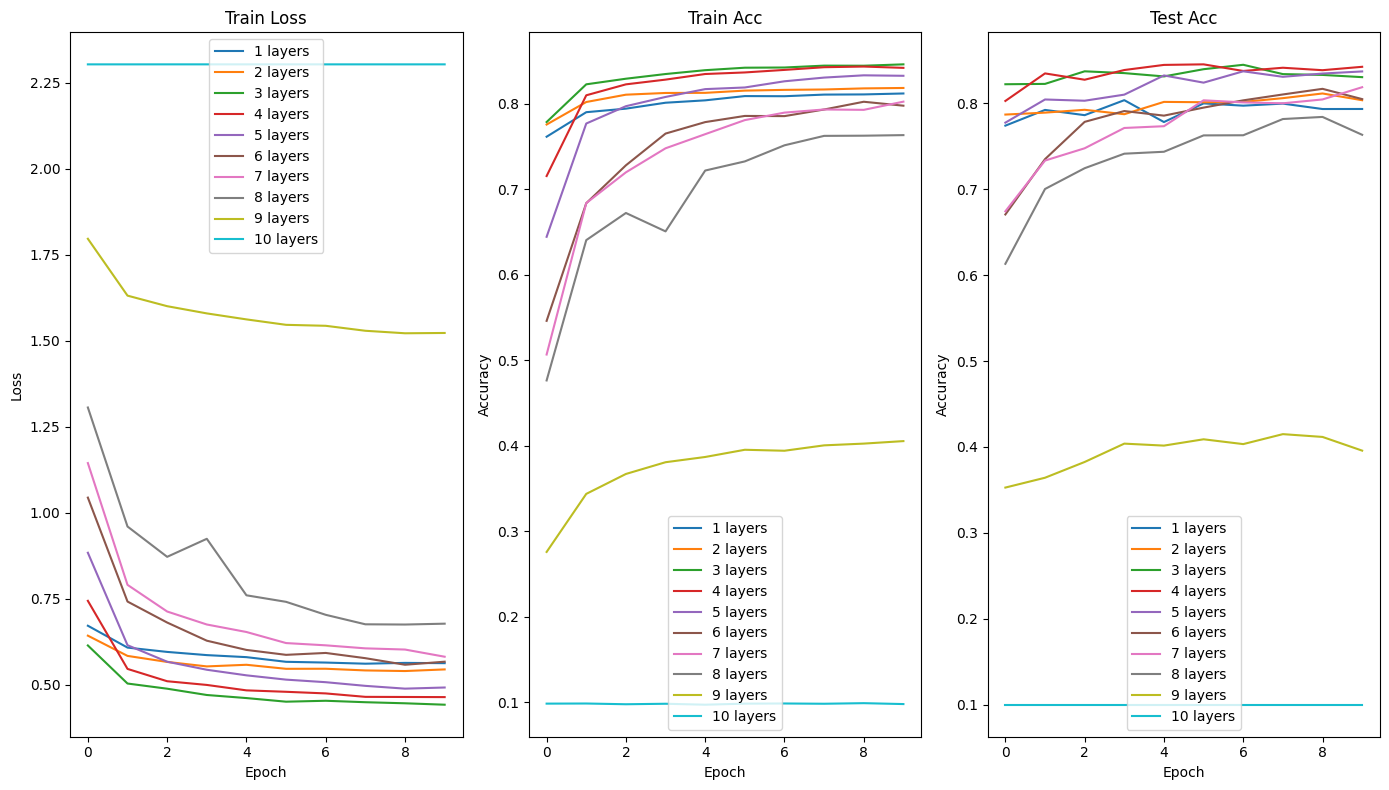

In [ ]:
our_layers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plot_results(expreriments_results, our_layers)

Видим, что на графиках с точностями модель с 10 слоями лежит ниже всех, и ее точность примерно 0.1. Выше нее находится модель с 9 слоями, ее точность лежит примерно между 0.3 и 0.4. Дальше видим, что чем вышем accuracy, тем модель имеет меньше слоев, то есть модель с меньшим количеством слоев показывает результаты лучше, чем модели с большим количеством. Самые высокие результаты показали модели с 3 и 4 слоями, их точность выше 0.8.